<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/mr0_diffusion_prep_STEAM_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq  &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null

# Diffusion prepared STEAM

## Dissuion prep
We use a T2_prep module 90 - 180 -90 and add diffusion gradients.

To spoil away the FID, which might have a different random phase than the stored diff-prepped magnetization, we add extra spoilers after the 180 and during the prewinder phase.

## Diffusion b-value calculation
I think I fixed the b-value calculation. One has to calculate either in SI or in the pulseq units of kHz/m. Both now given below.

In th b-value equation

b = γ² G² δ² (Δ−δ/3)

γ is 267512897  in rad/T
G is the gradient amplitude in T/m
Δ,δ are the two times lenght and distance in s


G=system.max_grad*1  yields the gradient amplitue in the pulseq native unit kHz/m

The conversion form kHz/m to mT/m is

1000/system.gamma

The conversion form kHz/m to SI units of T/m is

system.gamma/1000*1000

One can derive the b-value then in pulseq units (G) or in SI units (G_T_m) via

b_value_SI = (2 * np.pi * ystem.gamma)**2 * (G_T_m ** 2) * (delta ** 2) * (Delta - (delta / 3))

b_value_pulseq_SI = (2 * np.pi)** 2 * ((G) ** 2) * (delta ** 2) * (Delta - (delta / 3))

In [2]:
#@title  b-value calculation
#from https://github.com/HarmonizedMRI/Pulseq-diffusion/blob/main/demoSeq/writeEpiDiffusionRS_multishot_dti_v2_appa_R3_1003.m
import pypulseq as pp
import numpy as np
system = pp.Opts(max_grad=40,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)

def bFactCalc(g, delta, DELTA):
  sigma=1
  kappa_minus_lambda=1/3-1/2
  b= (2*np.pi * g * delta * sigma)**2 * (DELTA + 2*kappa_minus_lambda*delta) *1e-6   # changed only unit from   m^-2 to mm^-2 by *1e-6
  return b

bfactor = 1 #s/m^2
G=system.max_grad*1
gx_diff = pp.make_trapezoid(channel='z', amplitude=G, duration=20e-3, system=system)

delta = pp.calc_duration(gx_diff)   # Gradient duration in seconds
Delta = pp.calc_duration(gx_diff) +1.1e-3  # Time between gradients, assuming echo time is twice the gradient duration

G_T_m = G*1000/ system.gamma  / 1000  # gradient in T/m  , 1000/ system.gamma macht aus der pulseq einheit kHz/m wieder mT/m

print(f"Grad amplitude: {G:.2f} ")
print(f"Grad amplitude T/m: {G_T_m:.2f} ")
print(f"Grad amplitude: {gx_diff.amplitude:.2f} ")
maxG=40.0*system.gamma/1000
print(f"Grad amplitude: {maxG} ")
print(f"max_grad in mT/m: 40")

#b = γ² G² δ² (Δ−δ/3)

b_value_SI = (2*np.pi*system.gamma)**2 * (G_T_m ** 2) * (delta ** 2) * (Delta - (delta / 3))
b_value_pulseq_SI = (2*np.pi)** 2 * ((G) ** 2) * (delta ** 2) * (Delta - (delta / 3))

b_value = b_value_SI *1e-6 # m^-2 to mm^-2
b_value_pulseq=b_value_pulseq_SI  *1e-6 # m^-2 to mm^-2

print(f"Calculated b-value: {b_value:.2f} s/mm^2")
print(f"Calculated b-value_pulseq: {b_value:.2f} s/mm^2")
print(f"Calculated b-value (extern eq): {bFactCalc(G,delta,Delta):.2f} s/mm^2")


print(system.max_grad)
print(G_T_m)

print(gx_diff.amplitude)
gx_diff = pp.make_trapezoid(channel='z', amplitude=G,flat_time=delta, duration=20e-3, system=system)

print(gx_diff.amplitude)


b_value = ((system.gamma*1e-6) ** 2) * (G ** 2) * (delta ** 2) * (Delta - (delta / 3))*1e-6
print(f"Calculated b-value: {b_value:.2f} s/mm^2")



/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


Grad amplitude: 1703040.00 
Grad amplitude T/m: 0.04 
Grad amplitude: 1703040.00 
Grad amplitude: 1703040.0 
max_grad in mT/m: 40
Calculated b-value: 661.05 s/mm^2
Calculated b-value_pulseq: 661.05 s/mm^2
Calculated b-value (extern eq): 661.05 s/mm^2
1703040.0
0.04
1703040.0
1703040.0
Calculated b-value: 30353.31 s/mm^2


Calculated b-value: 0.00 s/mm^2
VoxelGridPhantom
size = tensor([0.1920, 0.1920, 0.0800])


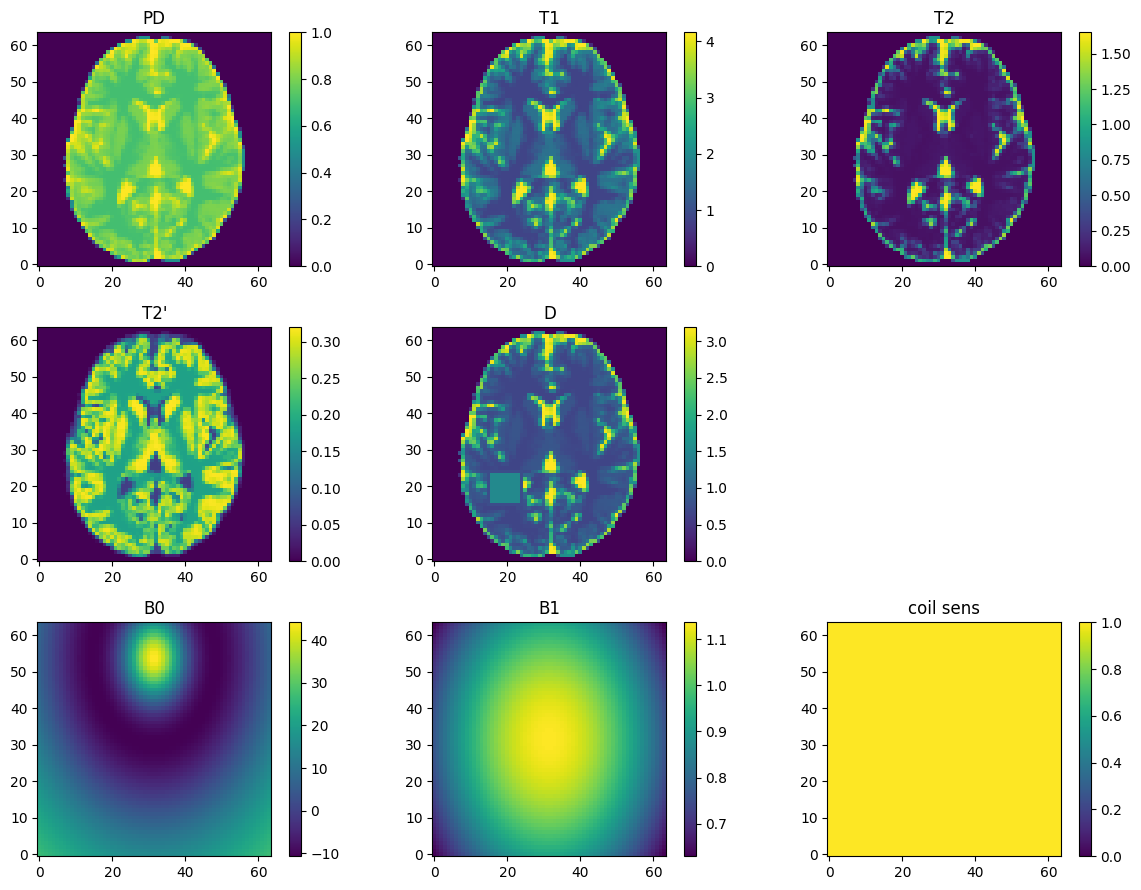

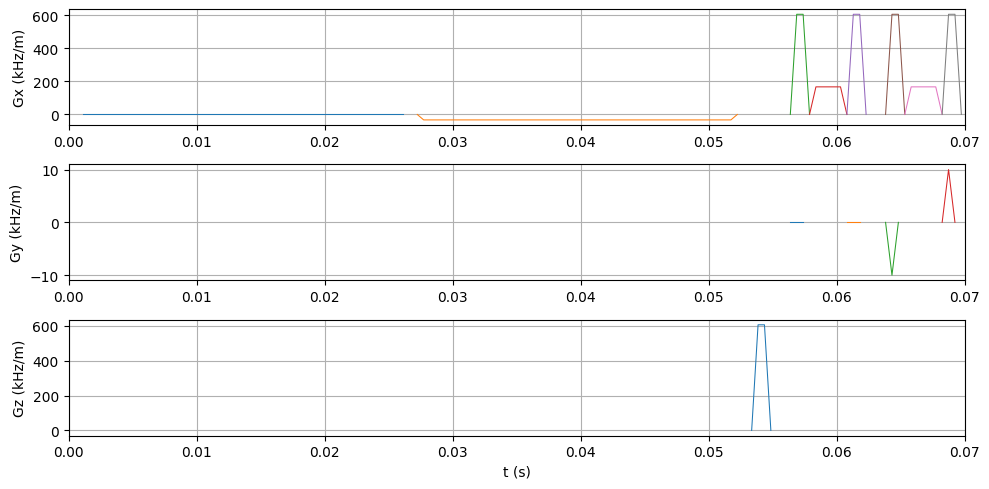

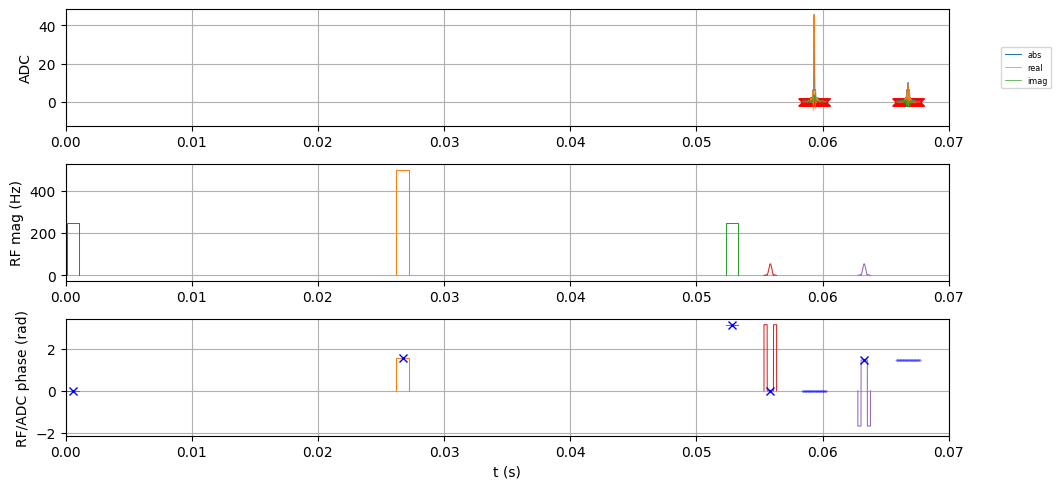

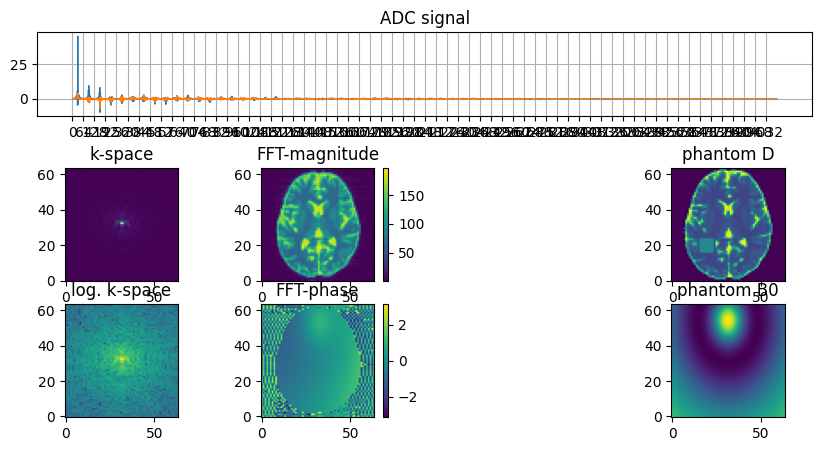

In [8]:
# @title seq + sim
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'mr0_diffusion_prepped_STEAM_2D'

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
seq = pp.Sequence()

fov = 200e-3
slice_thickness = 8e-3
Nread=64
Nphase=64

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle= 5 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

rf90 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf180 = pp.make_block_pulse(flip_angle=180 * np.pi / 180, phase_offset=90 * np.pi/180, duration=1e-3, system=system)
rf90_ = pp.make_block_pulse(flip_angle=90 * np.pi / 180, phase_offset=180 * np.pi/180,duration=1e-3, system=system)

dwell= 3e-5
# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread/fov, flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)

STEAM_spoil_factor=2 # @param {type: "slider",min:0, max:3, step:0.1}
gx_m  = -gx.area*STEAM_spoil_factor
#we will add the STE selecting gradient gx_m
# at two positions: 1. inverted to the gx_pre and 2. to the gx_diff2
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2 + (-gx_m), duration=1.5e-3, system=system) # add here -gx_m

gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=1.5e-3, system=system)
gz_spoil = pp.make_trapezoid(channel='z', area=1.5 * gx.area, duration=1.5e-3, system=system)


# This is the diffusion preparation block (this will not work on a real scanner, there you need a STEAM)

diff_prep = True # @param {type: "boolean"}
if diff_prep:
  G=system.max_grad*1
else:
  G=1e-12

gx_diff = pp.make_trapezoid(channel='x', amplitude=G, duration=25e-3, system=system)
# to the second gradient the STE selecting gradient gx_m is added
gx_diff2 = pp.make_trapezoid(channel='x', area=gx_diff.area+gx_m, duration=25e-3, system=system) # diff + spoil

seq.add_block(rf90)
seq.add_block(gx_diff)
seq.add_block(rf180)
seq.add_block(gx_diff2)
seq.add_block(rf90_)
seq.add_block(gz_spoil)

# b-value calculation
G = gx_diff.amplitude
delta =  pp.calc_duration(gx_diff)  # Gradient duration in seconds
Delta = pp.calc_duration(gx_diff) +pp.calc_duration(rf180)  # Time between gradients, assuming echo time is twice the gradient duration

#b = γ² G² δ² (Δ−δ/3)
b_value_pulseq_SI = (2*np.pi)** 2 * ((G) ** 2) * (delta ** 2) * (Delta - (delta / 3))
b_value_pulseq=b_value_pulseq_SI  *1e-6        # m^-2 to mm^-2
print(f"Calculated b-value: {b_value_pulseq:.2f} s/mm^2")


# ======
# CONSTRUCT READOUT SEQUENCE  rf and gradient spoiled centric flash
# ======
rf_phase = 0
rf_inc   = 0
rf_spoiling_inc = 84

##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1)
## centric reordering
permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
phenc_centr = phenc[permvec]

for jj in range(0, Nphase):  # e.g. -64:63
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    seq.add_block(rf1)
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]         # increment additional pahse

    gp = pp.make_trapezoid(channel='y', area=phenc_centr[jj]/fov, duration=1e-3, system=system)

    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.brainweb('subject05.npz')
obj_p = obj_p.interpolate(sz[0], sz[1], 32).slices([15])
obj_p.size[2]=0.08
# (ii) insert rectangular "Tumor"
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
# mr0 uses D in units of 10^-3 * mm ^2/s  this is the same as µm^2/ms

obj_p.D*=1
if 1:
    # construct tumor border region
    for ii in range(15, 25):
        for jj in range(15, 25):
            obj_p.D[ii, jj] = torch.tensor(0.75)

    # construct tumor filling
    for ii in range(16, 24):
        for jj in range(16, 24):
            obj_p.D[ii, jj] = torch.tensor(1.5)

# Store PD and B0 for comparison
D = obj_p.D
B0 = obj_p.B0
D=obj_p.D
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
#seq0.plot_kspace_trajectory()
# Simulate the sequence
#graph = mr0.compute_graph(seq0, obj_p, 5000, 1e-8)
#signal = mr0.execute_graph(graph, seq0, obj_p, min_emitted_signal=1e-8,min_latent_signal=1e-8,print_progress=False)

graph = mr0.compute_graph(seq0, obj_p, 2000, 1e-4)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False,time_range=(0,0.07))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

ipermvec = np.argsort(permvec)

kspace=kspace[:,ipermvec]
# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fft
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(345)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom D')
mr0.util.imshow(D)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
mr0.util.imshow(B0)

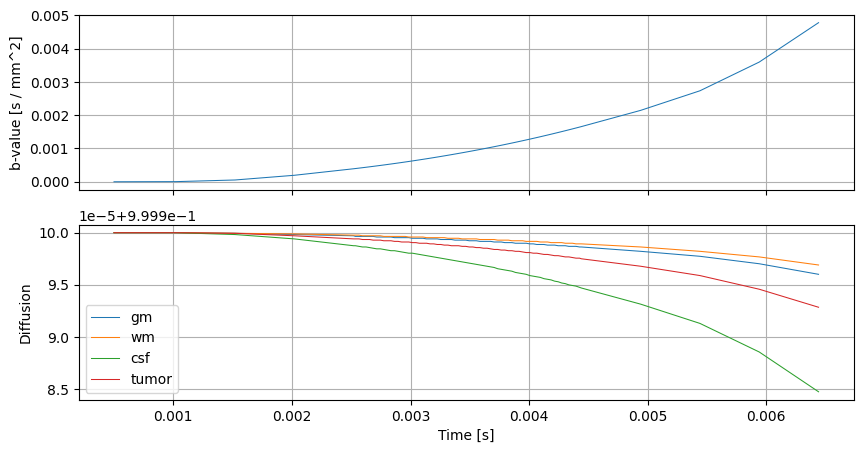

In [4]:
# Exemplary calculation of b-values and diffusion of simulated tissues for a single repetition

traj = seq0[10].gradm.cumsum(0)[:-2]
dt = seq0[10].event_time[:-2]
time = dt.cumsum(0)

k2 = traj[:, :3]
k1 = torch.zeros_like(k2)
k1[1:, :] = k2[:-1, :]
# Integrate over each event to get b factor (lin. interp. grad)
b = 1/3 * dt * (k1**2 + k1*k2 + k2**2).sum(1)  # s / m^2

# typical ADC values: 10^-3 mm^2/s = 10^-9 m^2 / s
# typical DWI b-values: up to 4000 s / mm^2

diffusion_gm = torch.exp(-1e-9 * 0.83 * torch.cumsum(b, 0)[:, None])
diffusion_wm = torch.exp(-1e-9 * 0.65 * torch.cumsum(b, 0)[:, None])
diffusion_csf = torch.exp(-1e-9 * 3.19 * torch.cumsum(b, 0)[:, None])
diffusion_tumor = torch.exp(-1e-9 * 1.5 * torch.cumsum(b, 0)[:, None])


plt.figure()
ax1 = plt.subplot(211)
plt.plot(time, b.cumsum(0) * 1e-6)
plt.ylabel("b-value [s / mm^2]")
plt.grid()
plt.tick_params("x", labelbottom=False)
plt.subplot(212, sharex=ax1)
plt.plot(time, diffusion_gm, label="gm")
plt.plot(time, diffusion_wm, label="wm")
plt.plot(time, diffusion_csf, label="csf")
plt.plot(time, diffusion_tumor, label="tumor")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Diffusion")
plt.show()